In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Multiply, Add, Layer, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Layer to subtract from 1
class SubtractFromOne(Layer):
    def call(self, inputs):
        return 1.0 - inputs

# Custom Layer to extract a specific feature (replacing Lambda layers that slice inputs)
class ExtractFeature(Layer):
    def __init__(self, index, **kwargs):
        super(ExtractFeature, self).__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        return inputs[:, :, self.index]

# Custom R2 score metric
def r2_score_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def train_and_evaluate_lstm_model(target_variable, flag_train=True, _epochs=100, _batch_size=10):
    mgh_data = pd.read_excel("lstm-datasets-10-days.xlsx")
    features = ['Timesteps [5 minutes]', f'{target_variable} (Predicted GL)', f'{target_variable} (Predicted NN)']
    
    X = mgh_data[features]
    y = mgh_data[f'{target_variable} (Actual)']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
    X_train_reshaped = X_train.values.reshape((X_train.shape[0], -1, X_train.shape[1]))
    X_test_reshaped = X_test.values.reshape((X_test.shape[0], -1, X_test.shape[1]))

    if flag_train:
        time_steps = X_train_reshaped.shape[1]
        features_count = X_train_reshaped.shape[2]

        # Define the input layer with the appropriate shape
        input_layer = Input(shape=(time_steps, features_count), name='input_layer')

        # First LSTM layer with 64 units and dropout
        lstm_output_1 = LSTM(units=64, return_sequences=True)(input_layer)
        dropout_1 = Dropout(0.2)(lstm_output_1)

        # Second LSTM layer with 32 units and dropout
        lstm_output_2 = LSTM(units=32, return_sequences=True)(dropout_1)
        dropout_2 = Dropout(0.2)(lstm_output_2)

        # Third LSTM layer with 16 units and dropout
        lstm_output_3 = LSTM(units=16, return_sequences=False)(dropout_2)
        dropout_3 = Dropout(0.2)(lstm_output_3)

        # Dense layer followed by dropout
        w_physics = Dense(1, activation='sigmoid')(dropout_3)

        # Custom layer to subtract from 1
        w_nn = SubtractFromOne()(w_physics)

        # Extract specific features
        q_physics_input = ExtractFeature(index=1, name='q_physics_input')(input_layer)
        q_nn_input = ExtractFeature(index=2, name='q_nn_input')(input_layer)

        # Calculate the final output
        y_hat_physics = Multiply()([q_physics_input, w_physics])
        y_hat_nn = Multiply()([q_nn_input, w_nn])
        y_hat = Add()([y_hat_physics, y_hat_nn])

        # Create the model
        model = Model(inputs=input_layer, outputs=y_hat)
        
        adam = Adam(learning_rate=0.001, use_ema=True, ema_momentum=0.9)
        
        model.compile(optimizer=adam, loss='mse', metrics=['mae', r2_score_metric])

        history = model.fit(X_train_reshaped, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

        # Save model architecture and weights
        model_json = model.to_json()
        with open(f"lstm-dropout-models/{target_variable.replace(' ', '_')}_lstm_model.json", "w") as json_file:
            json_file.write(model_json)
        model.save_weights(f"lstm-dropout-models/{target_variable.replace(' ', '_')}_lstm_model.weights.h5")

        # Predict the test set after training
        y_hat_test = model.predict(X_test_reshaped)

    else:
        # Load model architecture and weights
        with open(f"lstm-dropout-models/{target_variable.replace(' ', '_')}_lstm_model.json", "r") as json_file:
            loaded_model_json = json_file.read()
            loaded_model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={'r2_score_metric': r2_score_metric, 'SubtractFromOne': SubtractFromOne, 'ExtractFeature': ExtractFeature})

        loaded_model.load_weights(f"lstm-dropout-models/{target_variable.replace(' ', '_')}_lstm_model.weights.h5")
        loaded_model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_metric])

        # Predict the test set using the loaded model
        y_hat_test = loaded_model.predict(X_test_reshaped)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)

    if flag_train:
        # Plot training history
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')
        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()

    # Plot of actual vs. predicted over time
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()



Epoch 1/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1908 - mae: 0.3521 - r2_score_metric: 0.6136 - val_loss: 0.1559 - val_mae: 0.3307 - val_r2_score_metric: 0.5611
Epoch 2/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1767 - mae: 0.3453 - r2_score_metric: 0.4113 - val_loss: 0.1539 - val_mae: 0.3329 - val_r2_score_metric: 0.5622
Epoch 3/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1697 - mae: 0.3419 - r2_score_metric: 0.5552 - val_loss: 0.1553 - val_mae: 0.3297 - val_r2_score_metric: 0.5599
Epoch 4/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1670 - mae: 0.3400 - r2_score_metric: 0.5696 - val_loss: 0.1538 - val_mae: 0.3295 - val_r2_score_metric: 0.5648
Epoch 5/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1686 - mae: 0.3390 - r2_score_metric: 0.6107 - val_loss: 0.1524 - val_mae: 0.3298 - val_r2_score_metric: 0.5648
Epoch 6/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1646 - mae: 0.3364 - r2_score_metric: 0.5471 - val_loss: 0.15

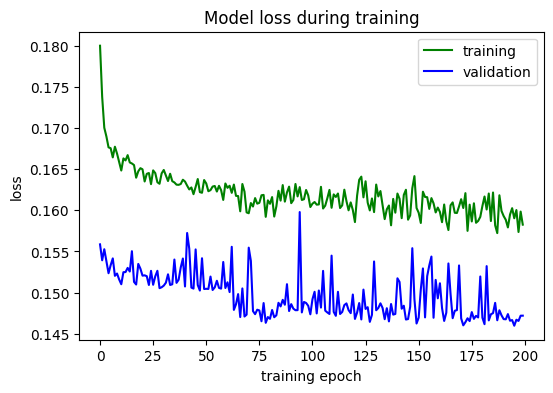

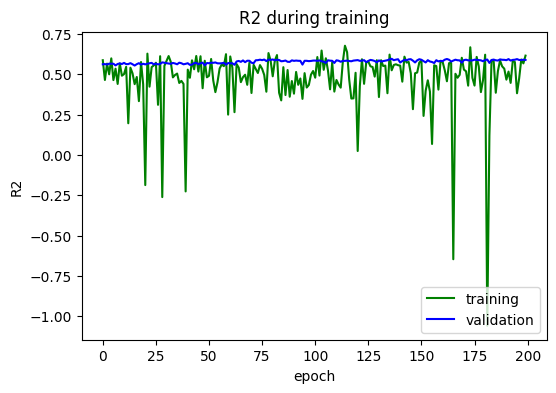

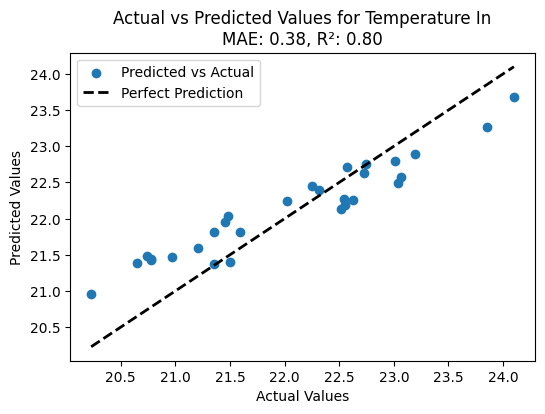

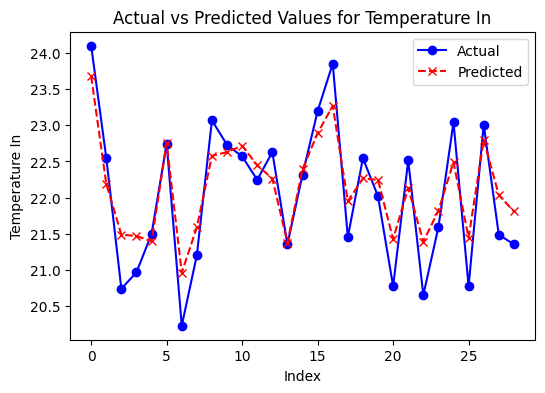

Epoch 1/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 138.2228 - mae: 8.7557 - r2_score_metric: -19.8791 - val_loss: 8.5467 - val_mae: 2.4229 - val_r2_score_metric: -0.5685
Epoch 2/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4673 - mae: 2.5936 - r2_score_metric: -0.5368 - val_loss: 8.2858 - val_mae: 2.3711 - val_r2_score_metric: -0.5233
Epoch 3/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.5554 - mae: 2.5550 - r2_score_metric: -0.5611 - val_loss: 8.1881 - val_mae: 2.3515 - val_r2_score_metric: -0.5064
Epoch 4/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.8624 - mae: 2.4499 - r2_score_metric: -0.6730 - val_loss: 8.1387 - val_mae: 2.3415 - val_r2_score_metric: -0.4978
Epoch 5/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.8196 - mae: 2.4698 - r2_score_metric: -1.0256 - val_loss: 8.1112 - val_mae: 2.3360 - val_r2_score_metric: -0.4930
Epoch 6/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0520 - mae: 2.4993 - r2_score_metric: -0.9330 - v

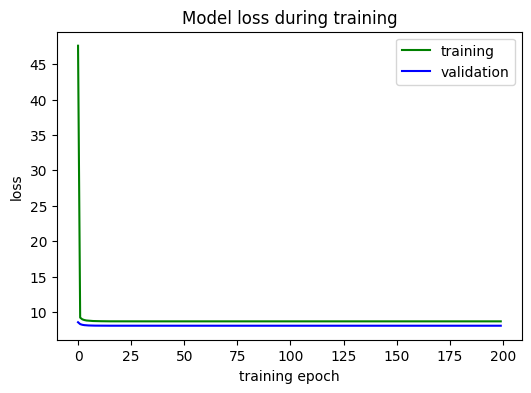

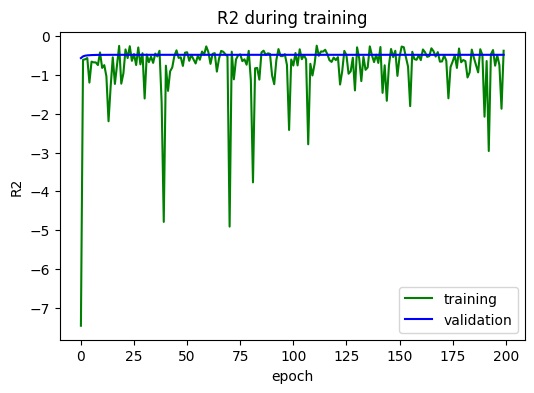

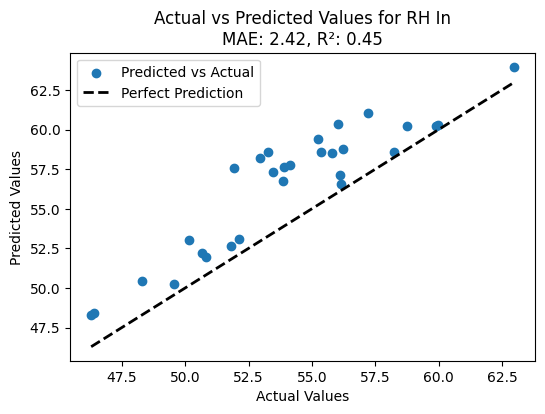

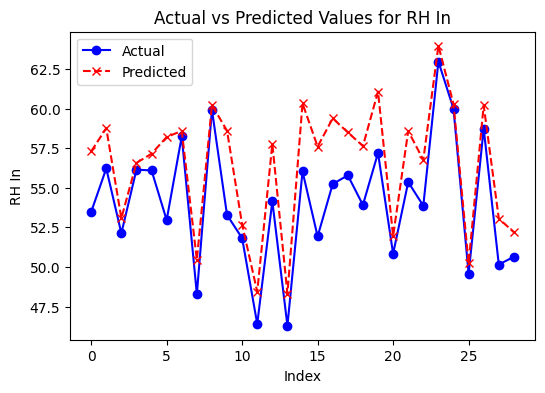

Epoch 1/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.9756 - mae: 0.6875 - r2_score_metric: -0.9290 - val_loss: 0.3415 - val_mae: 0.3420 - val_r2_score_metric: 0.8484
Epoch 2/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3965 - mae: 0.3780 - r2_score_metric: 0.0132 - val_loss: 0.3400 - val_mae: 0.3409 - val_r2_score_metric: 0.8493
Epoch 3/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3904 - mae: 0.3818 - r2_score_metric: -1.2628 - val_loss: 0.3410 - val_mae: 0.3357 - val_r2_score_metric: 0.8558
Epoch 4/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4289 - mae: 0.3831 - r2_score_metric: -4.8244 - val_loss: 0.3329 - val_mae: 0.3388 - val_r2_score_metric: 0.8488
Epoch 5/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3544 - mae: 0.3580 - r2_score_metric: 0.5598 - val_loss: 0.3244 - val_mae: 0.3398 - val_r2_score_metric: 0.8485
Epoch 6/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3772 - mae: 0.3711 - r2_score_metric: 0.5593 - val_loss: 0.

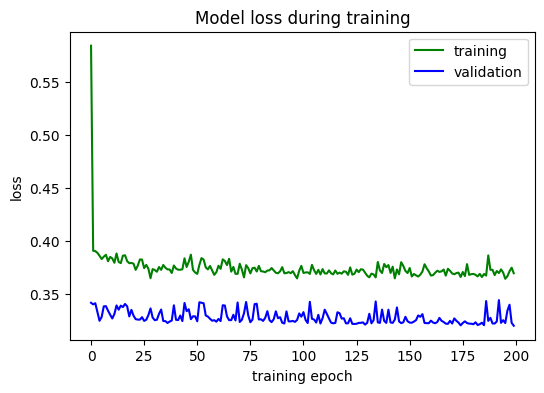

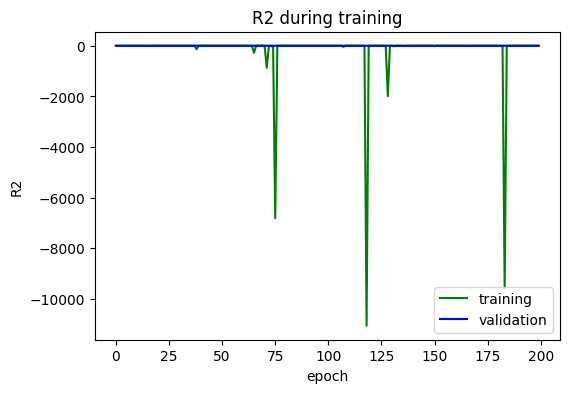

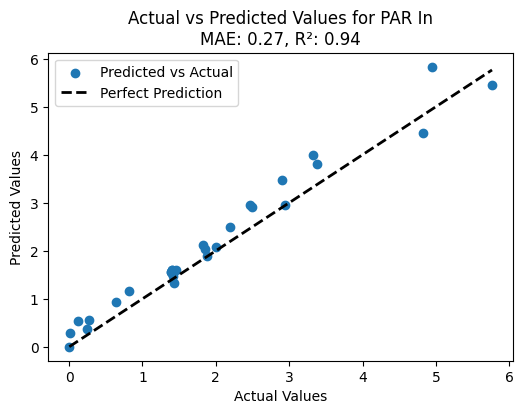

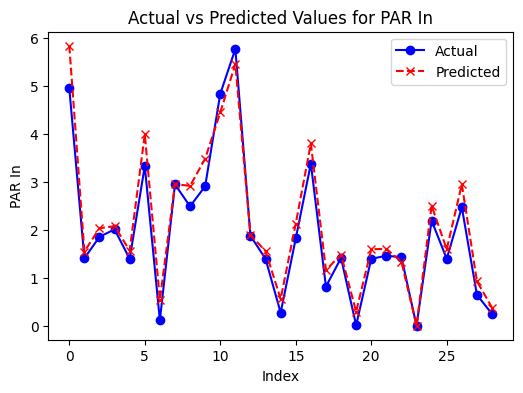

Epoch 1/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 69.6972 - mae: 6.9132 - r2_score_metric: -2228946432.0000 - val_loss: 29.5383 - val_mae: 4.7922 - val_r2_score_metric: -786555072.0000
Epoch 2/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 28.0099 - mae: 4.6410 - r2_score_metric: -857208640.0000 - val_loss: 29.2148 - val_mae: 4.7659 - val_r2_score_metric: -776232768.0000
Epoch 3/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 27.7541 - mae: 4.6652 - r2_score_metric: -811235968.0000 - val_loss: 29.1209 - val_mae: 4.7583 - val_r2_score_metric: -773234240.0000
Epoch 4/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 28.4188 - mae: 4.6921 - r2_score_metric: -800833664.0000 - val_loss: 29.0780 - val_mae: 4.7549 - val_r2_score_metric: -771866560.0000
Epoch 5/200
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 27.4782 - mae: 4.6088 - r2_score_metric: -818548096.0000 - val_loss: 29.0570 - val_mae: 4.7532 - val_r2_score_metric: -771194112.0000
Epoch 6/200
572/572 ━━━━

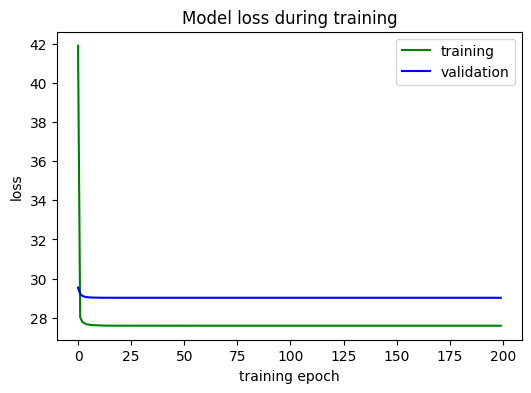

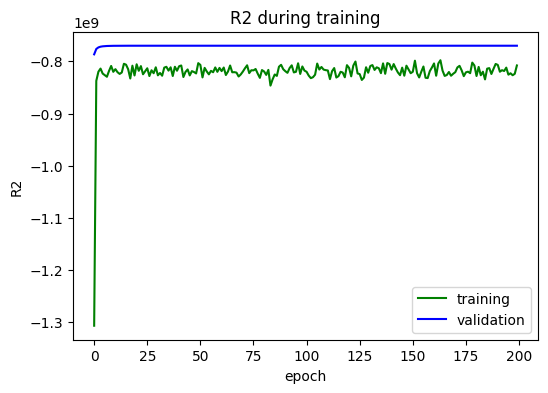

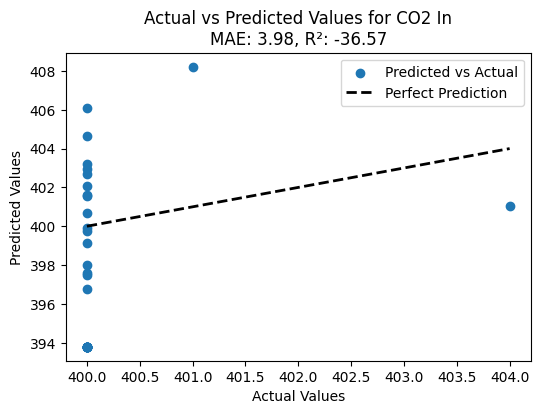

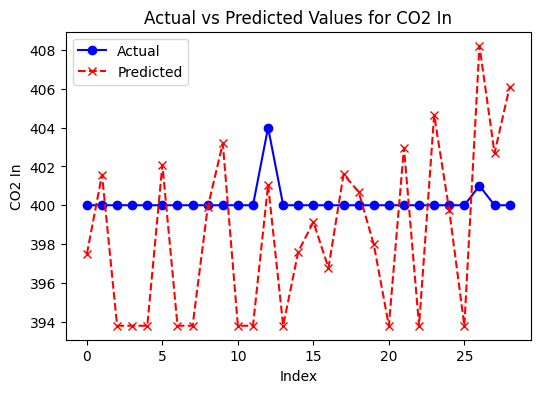

In [2]:
target_variable = ['Temperature In', 'RH In', 'PAR In', 'CO2 In']

for i in target_variable:
    train_and_evaluate_lstm_model(i, flag_train=True, _epochs=200, _batch_size=4)